# KDE

Kernel Density Estimation (KDE) is a non-parametric way of estimating the probability density function (pdf) of ANY distribution given a finite number of its samples. The pdf of a random variable X given finite samples ($x_i$), as per KDE formula, is given by:

$$ pdf(x)=\frac{1}{nh}\sum_{i=1}^{n} K ( \frac{||x − x_i||}{h} )$$

In the above equation, $K()$ is called the kernel - a symmetric function that integrates to $1$. 

$h$ is called the **kernel bandwidth** which controls how smooth (or spread-out) the kernel is. 

The most commonly used kernel is the normal distribution function.

$$ K(x)=\frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{2}} $$

The free parameters of kernel density estimation are the kernel, which specifies the shape of the distribution placed at each point, and the kernel bandwidth, which controls the size of the kernel at each point. In practice, there are many kernels you might use for a kernel density estimation: in particular, the Scikit-Learn KDE implementa‐ tion supports one of six kernels, which you can read about in Scikit-Learn’s Density Estimation documentation.

[source 1](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html)

[source 2](http://shogun-toolbox.org/notebook/latest/KernelDensity.html)

In [1]:
%matplotlib inline
from dataset import Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns; sns.set()
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_score
from sklearn.neighbors import KernelDensity
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import warnings

warnings.simplefilter(action='ignore')

np.random.seed(1)

/Users/renero/miniconda3/envs/ie/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Parameters

Setup all the parameters that I will need in later cells in a single place.

In [2]:
# pdf function for plotting
n_samples = 100
x_min = 0.001
x_max = 15

# parameters of the distribution
mu1 = 4
sigma1 = 1
mu2 = 8
sigma2 = 2

# Parameters of the KDE
bandwidth = 0.5

## Random data

Let's generate a random set of points following a known distribution. We will later try to approximate that "unknown" distribution using KDE.

In [ ]:
x = np.linspace(x_min, x_max, n_samples)
y = 0.5*(stats.norm(mu1, sigma1).pdf(x)+stats.norm(mu2, sigma2).pdf(x))

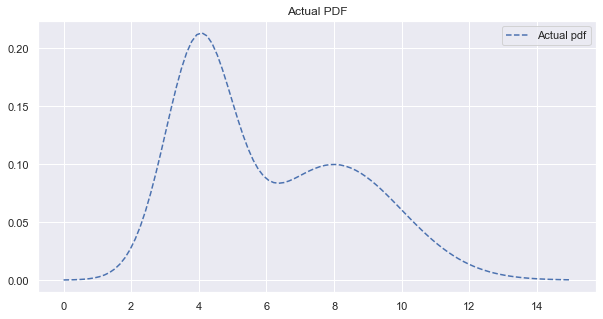

In [3]:
# plot actual pdf
plt.figure(figsize=(10, 5))
plt.plot(x, y, 'b--', label="Actual pdf")
plt.legend(numpoints=1)
plt.title('Actual PDF')
plt.show();

Generate some samples with the parameters of the distributions proposed above, and plot them over the X axis. Those are our dataset, and we have to run KDE to estimate what is their distribution later.

In [ ]:
def generate_samples(n_samples, mu1, sigma1, mu2, sigma2):
    samples1 = np.random.normal(mu1, sigma1, (1, int(n_samples/2)))
    samples2 = np.random.normal(mu2, sigma2, (1, int(n_samples/2)))
    samples = np.concatenate((samples1, samples2), 1)
    return samples

samples = generate_samples(n_samples, mu1, sigma1, mu2, sigma2)
samples = samples.T

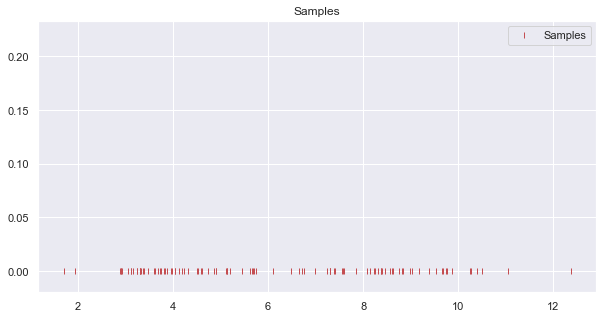

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(samples, np.zeros(n_samples), '|r', label="Samples")
plt.legend(numpoints=1)
plt.title('Samples')
plt.ylim(-0.02, max(y)+0.02)
plt.show()

Run now our KDE estimate, using only 20 samples to see what it is capable of doing.

In [5]:
# Generate more samples
n_samples = 20
samples = generate_samples(n_samples, mu1, sigma1, mu2, sigma2)
samples = samples.T

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(samples)

# score_samples returns the log of the probability density
# `x_d` is a list of 20 equally spaced values between min and max
x_d = np.linspace(x_min, x_max, n_samples).reshape(-1, 1)
logprob = kde.score_samples(x_d)

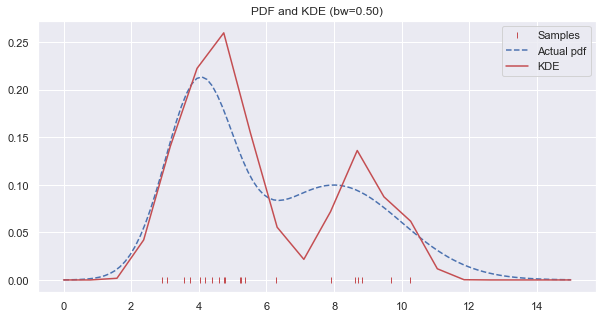

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(samples, np.zeros(n_samples), '|r', label='Samples')
plt.plot(x, y, 'b--', label="Actual pdf")
plt.plot(x_d, np.exp(logprob), 'r-', label='KDE')
plt.legend()
plt.title('PDF and KDE (bw={:.2f})'.format(bandwidth))
plt.show();

As you can see, with such a low number of samples and the bandwidth proposed, KDE makes a fair job in estimating what is the underlying distribution of the data. If you want the red plot to better fit the blue curve, increase the number of samples or play with the bandwidth, and results will improve.

Remember that each value of the "red" KDE estimate is the "estimated" probability of each value of the X axis. You can see that there're some regions where it is more likely to find values than in some others. That difference in probabilities gives you the ability (below) to build a classifier with this technique.

## GridSearch optimal bandwith

Now, let's find what is the optimal value for the bandwidth to be used in this specific example.

In [7]:
bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(samples);
bandwidth = grid.best_params_['bandwidth']
print('Optimal Bandwidth: {:.2f}'.format(bandwidth))

Optimal Bandwidth: 0.81


In [8]:
# instantiate and fit the KDE model over the samples
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(samples)

# score_samples returns the log of the probability density
x_d = np.linspace(x_min, x_max, n_samples).reshape(-1, 1)
logprob = kde.score_samples(x_d)

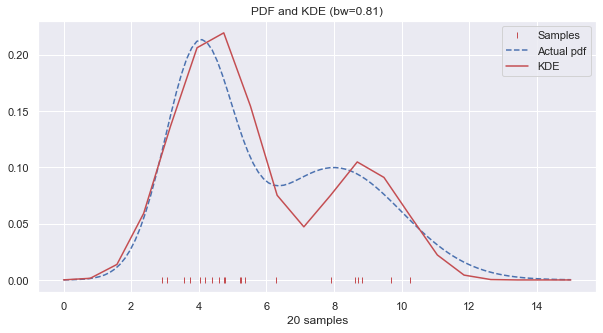

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(samples, np.zeros(n_samples), '|r', label='Samples')
plt.plot(x, y, 'b--', label="Actual pdf")
plt.plot(x_d, np.exp(logprob), 'r-', label='KDE')
plt.legend()
plt.title('PDF and KDE (bw={:.2f})'.format(bandwidth))
plt.xlabel('20 samples'); plt.show();

As expected, with an optimal value for the bandwidth we get a better fit of our KDE.

Check now what is the effect on the number of samples used to fit the KDE. Let's jump from 20 to 200, with same bandwidth.

In [10]:
# Generate more samples
n_samples = 200
samples = generate_samples(n_samples, mu1, sigma1, mu2, sigma2)
samples = samples.T

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(samples)

# score_samples returns the log of the probability density
x_d = np.linspace(x_min, x_max, n_samples).reshape(-1, 1)
logprob = kde.score_samples(x_d)

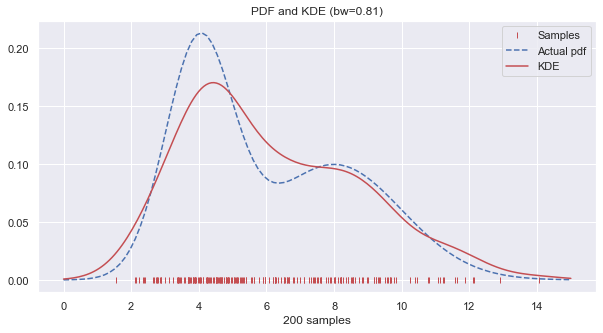

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(samples, np.zeros(n_samples), '|r', label='Samples')
plt.plot(x, y, 'b--', label="Actual pdf")
plt.plot(x_d, np.exp(logprob), 'r-', label='KDE')
plt.legend()
plt.title('PDF and KDE (bw={:.2f})'.format(bandwidth))
plt.xlabel('200 samples')
plt.show();

The bell shape is now smoother, though we're loosing detail on the second "bump" over the value of "8". Probably we should re-check what is the optimal bandwidth again with this number of samples.

In [12]:
bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(samples);
bandwidth = grid.best_params_['bandwidth']
print('Optimal Bandwidth: {:.2f}'.format(bandwidth))

Optimal Bandwidth: 0.71


Plot the results with the optimal bandwidth obtained for the 200 samples.

In [13]:
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(samples)

# score_samples returns the log of the probability density
x_d = np.linspace(x_min, x_max, n_samples).reshape(-1, 1)
logprob = kde.score_samples(x_d)

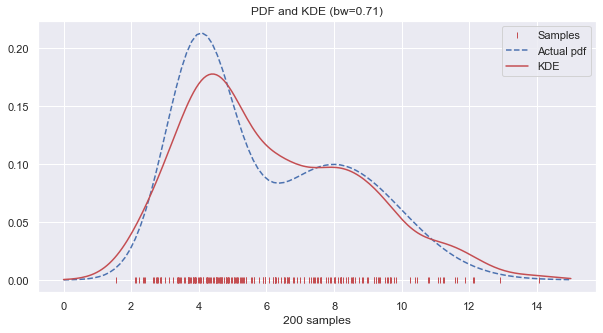

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(samples, np.zeros(n_samples), '|r', label='Samples')
plt.plot(x, y, 'b--', label="Actual pdf")
plt.plot(x_d, np.exp(logprob), 'r-', label='KDE')
plt.legend()
plt.title('PDF and KDE (bw={:.2f})'.format(bandwidth))
plt.xlabel('200 samples')
plt.show();

Now we can see that the optimal bandwidth over the specific 200 samples used builds an almost perfect fit over the distribution of the data.

## KDE Classifier over HR dataset

Mostly from [here](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.13-Kernel-Density-Estimation.ipynb). Let's use a KDE Classifier to solve the classification problem in the HR dataset.

The general approach for **generative classification** is this:

1. Split the training data by label.
2. For each set, fit a KDE to obtain a generative model of the data. This allows you for any observation $x$ and label $y$ to compute a likelihood $P(x~|~y)$.
3. From the number of examples of each class in the training set, compute the class prior, $P(y)$.
4. For an unknown point $x$, the posterior probability for each class is $P(y~|~x) \propto P(x~|~y)P(y)$. The class which maximizes this posterior is the label assigned to the point.

The algorithm is straightforward and intuitive to understand; the more difficult piece is couching it within the Scikit-Learn framework in order to make use of the grid search and cross-validation architecture.

### Load the HR dataset

Perform basic transformation over the features. We will only use numerical features.

In [15]:
hr = Dataset('./data/hr-analytics.zip')
hr.set_target('left')
hr.to_categorical(['number_project', 'time_spend_company',
                   'promotion_last_5years', 'Work_accident'])
hr.scale()
hr.summary('numerical')

Features Summary (numerical):
'satisfaction_level'  : float64    Min.(-2.1) 1stQ(-0.6) Med.(0.10) Mean(2.88) 3rdQ(0.83) Max.(1.55)
'last_evaluation'     : float64    Min.(-2.0) 1stQ(-0.9) Med.(0.02) Mean(-3.9) 3rdQ(0.89) Max.(1.65)
'average_montly_hours': float64    Min.(-2.1) 1stQ(-0.9) Med.(-0.0) Mean(-8.7) 3rdQ(0.88) Max.(2.18)


In [16]:
class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        if isinstance(y, pd.DataFrame):
            y = y.values
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [17]:
bandwidths = 10 ** np.linspace(-1, 0, 10)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths},
                   scoring='accuracy')
grid.fit(hr.select('numerical'), hr.target)
scores = grid.cv_results_['mean_test_score']

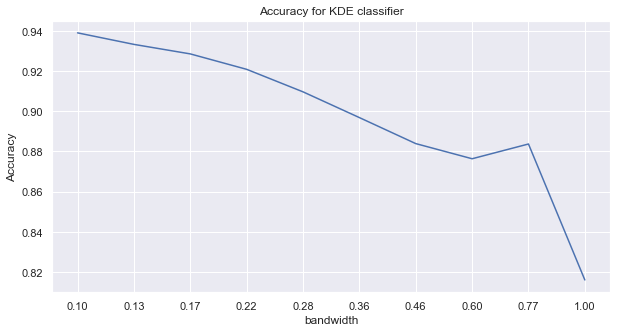

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(scores)
plt.title('Accuracy for KDE classifier')
plt.ylabel('Accuracy')
plt.xlabel('bandwidth')
plt.xticks(np.arange(len(bandwidths)), ['{:.2f}'.format(b) for b in bandwidths])
plt.show()

We see that this not-so-naive Bayesian KDE classifier reaches a cross-validation accuracy of just over 93%; this is compared to around 76% for the naive Bayesian classification:

In [19]:
cross_val_score(GaussianNB(), hr.select('numerical'), hr.target).mean()

0.763850639101923

## HR Example

Load and perform the basic transofrmations. In our case, we will try to solve the problem using only the true numerical features in it.

In [20]:
hr = Dataset('data/hr-analytics.zip')
hr.set_target('left')
hr.to_categorical(['number_project', 'time_spend_company',
                   'promotion_last_5years', 'Work_accident'])
hr.drop_columns(hr.names('categorical'))
hr.summary()

Features Summary (all):
'satisfaction_level'  : float64    Min.(0.09) 1stQ(0.44) Med.(0.64) Mean(0.61) 3rdQ(0.82) Max.(1.0)
'last_evaluation'     : float64    Min.(0.36) 1stQ(0.56) Med.(0.72) Mean(0.71) 3rdQ(0.87) Max.(1.0)
'average_montly_hours': float64    Min.(96.0) 1stQ(156.) Med.(200.) Mean(201.) 3rdQ(245.) Max.(310.)
'left'                : float64    Min.(0.0) 1stQ(0.0) Med.(0.0) Mean(0.23) 3rdQ(0.0) Max.(1.0)


### Train the classifier and estimate the performance

In [21]:
X, y = hr.split()

model = KDEClassifier(bandwidth=0.1)
model.fit(X.train, y.train)
cv_accuracies = cross_val_score(model, X.train, y.train, cv=5, scoring='accuracy')
print('Avg. Acc: {:.4f} +/- {:.4f}'.format(
    np.mean(cv_accuracies), np.std(cv_accuracies)))

Avg. Acc: 0.9019 +/- 0.0041


Obtain different metrics

In [22]:
y_pred = model.predict(X.test)
auc = roc_auc_score(y.test, y_pred)
acc = accuracy_score(y.test, y_pred)

print('AuC: {:.4f}'.format(auc))
print('Acc: {:.4f}'.format(acc))

AuC: 0.8707
Acc: 0.9123


### ROC Curve

In [ ]:
# roc curve and auc
probs = model.predict_proba(X.test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y.test, probs)
print('AUC: %.3f' % auc)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y.test, probs)

AUC: 0.959


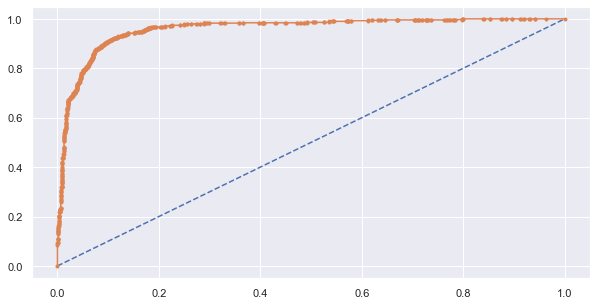

In [23]:
plt.figure(figsize=(10, 5))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show();